$$ y_{in} = F_{act}((I+n_{in} W_{in}) + bias) $$

$$ I^* = (W_{out}y_{in}) + n_{out} $$

$$ Cost = \sqrt{\langle|I-I^*|\rangle} + \lambda \langle r_s \rangle + \lambda \langle r_w \rangle$$

In [1]:
#Dependencies
import os

import numpy as np
import pylab as pl
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy as scipy

import sklearn.cluster as sklclu

import utils.plotutils as plu
import utils.imreadin as imr
import utils.aec as aec
import utils.train_model as tm
#import utils.dirutils as diru

#code to reload
import imp
imp.reload(plu)
imp.reload(imr)

#code to limit number of CPUs
maxcpus = 1
%env CUDA_VISIBLE_DEVICES=0

#image files
#ims = 'vh_corr'
#ims = 'vh_uncorr'
#ims = 'vhlognorm'
#ims = 'kyoto'
ims = 'whitenoise'

patch_multiplier = 1

%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'dpi' : 200} #plotting pretty

env: CUDA_VISIBLE_DEVICES=0


In [30]:
#parameters constant for all
imsparm = ims
patchparm = 4
fullimnormparm = False
patchmultiplierparm = 1
colorinvertparm = False

with tf.device('/cpu:0'):
    try:
        vhimgs
    except NameError:
        vhimgs, nimages = imr.load_images(imset = imsparm,
                                          patch_edge_size = patchparm,
                                          normalize_im = fullimnormparm,
                                          patch_multiplier = patchmultiplierparm,
                                          normalize_patch = False,
                                          invert_colors = False,
                                          start = 0,
                                          subset = 1000
                                         )
        
        tvhimgs, tnimages = imr.load_images(imset = imsparm,
                                            patch_edge_size = patchparm,
                                            normalize_im = fullimnormparm,
                                            patch_multiplier = patchmultiplierparm,
                                            normalize_patch = False,
                                            invert_colors = False,
                                            start = 5000,
                                            subset = 10
                                           )

        #only make anew dict and change these in params dict if we have reloaded images.
        params = {} #make a new dictionary
        #fill up our new dictionary
        params["ims"] = imsparm
        params['nimgs'] = np.shape(vhimgs)[0]
        params['normalize_full_im'] = fullimnormparm
        params["patchsize"] = patchparm
        params['patch_multiplier'] = patchmultiplierparm
        params['colorinvert'] = colorinvertparm


params["nimages"] = nimages
params["imxlen"] = params["patchsize"]
params["imylen"] = params["patchsize"]

#params for sweeping
sweep_neurons = [32]#[8,16,32] #[100] #[50,100,200] #[50,75,100,150,200]
sweep_nonlin1 = ['linear'] #['linear', 'sigmoid'] #['linear','sigmoid','relu'] , #'sigmoid',
sweep_nonlin2 = ['linear']
sweep_lambda_wgt_act = [[0,0]]; # [0.1,0] for center surround.
bsis = [1000]
sweep_batch_its = [[bsz, int((np.int(params['nimages']/bsz)))] for bsz in bsis] 
sweep_epochs = [1]
sweep_learning_rates = [0.001] #, 0.001, 0.005, 0.01, 0.015] 
sweep_noise_xs_rs = [[0,0]] #[[0,0],[0.1,0],[0.01,0],[0,0.1],[0,0.01]] 


In [31]:
for neurons in sweep_neurons:
    params['nneurons'] = neurons
    for nonlin1 in sweep_nonlin1:
        params['nonlin1'] = nonlin1
        for nonlin2 in sweep_nonlin2:
            params['nonlin2'] = nonlin2
            for lambda_wgt,lambda_act in sweep_lambda_wgt_act:
                params['lambda_wgt'] = lambda_wgt    
                params['lambda_act'] = lambda_act
                for batchsize, iterations in sweep_batch_its:
                    params['batchsize'] = batchsize
                    params['iterations'] = iterations
                    for epos in sweep_epochs:
                        params['epochs'] = epos
                        for lr in sweep_learning_rates:
                            params['learning_rate'] = lr
                            for xs,rs in sweep_noise_xs_rs:
                                params['noise_x'] = xs
                                params['noise_r'] = rs

                                #make our model
                                encoding_model = aec.aec_model(params)
                                
                                #train it'
                                [encoding_model,
                                cost_evolution,
                                wmean_evolution,
                                inweights_evolution,
                                outweights_evolution,                   
                                activation_evolution,
                                inbias_evolution,
                                weights_kernel_in,
                                test_patches,
                                test_recons,
                                test_inweights_ordered,
                                test_outweights_ordered,
                                test_acts_ordered,
                                test_acts] = tm.train_model(encoding_model,vhimgs,tvhimgs)

                                #save model
                                print('Saving Plots...')
                                plu.save_plots(encoding_model,
                                               cost_evolution,
                                               wmean_evolution,
                                               inweights_evolution,
                                               outweights_evolution,
                                               activation_evolution,
                                               inbias_evolution,
                                               weights_kernel_in,
                                               test_patches,
                                               test_recons,
                                               test_inweights_ordered,
                                               test_outweights_ordered,
                                               test_acts_ordered)
                                
                                print('Run Finished!')
print("*** Parameter Sweep Finished! ***")

Compressing by 0.5 for a total of 32 neurons
neurons=32, noise_in=0, noise_out=0, lambda_w=0, lambda_act=0
Training 6250 iterations in 1 epochs... 
0, 625, 1250, 1875, 2500, 3125, 3750, 4375, 5000, 5625, Running Test Set...
Saving Plots...
Run Finished!
*** Parameter Sweep Finished! ***


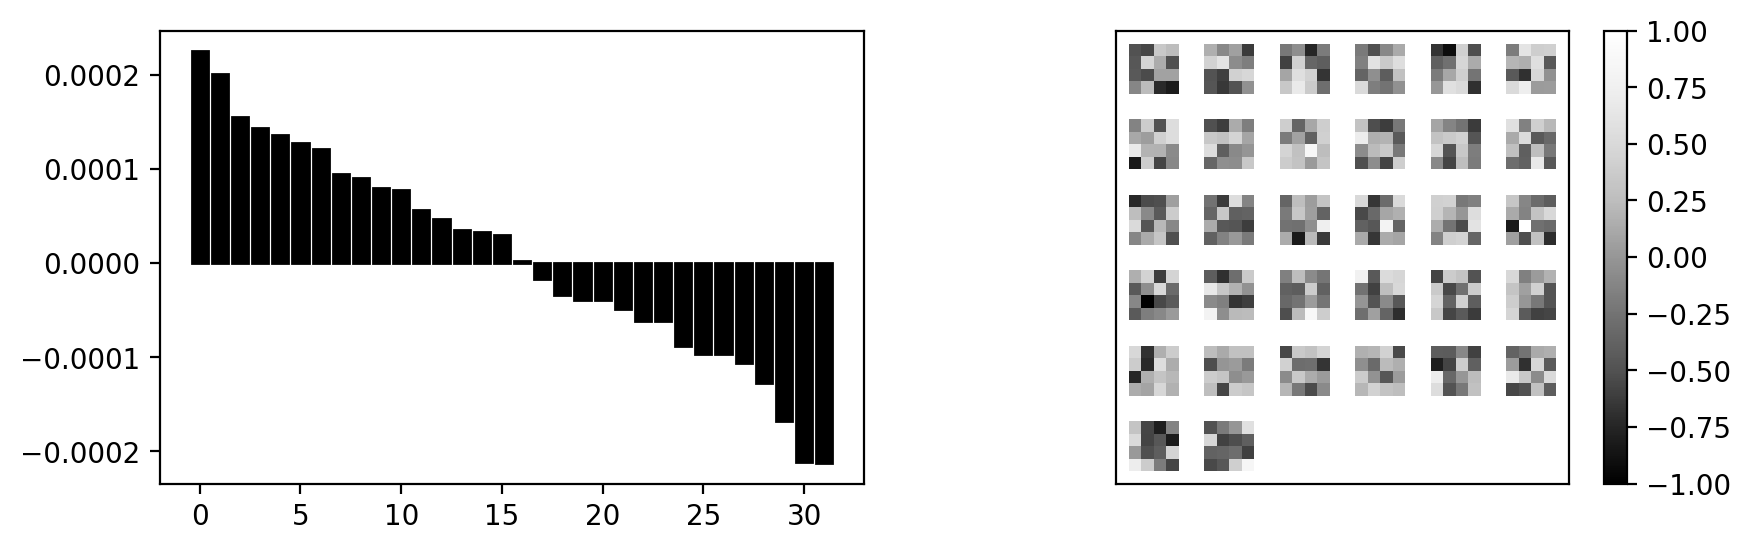

In [32]:
imp.reload(plu)
fw = test_inweights_ordered.reshape(encoding_model.params['imxlen'],
                                     encoding_model.params['imylen'],
                                     encoding_model.params['nneurons']).T
p = plu.display_data_acts_tiled(fw,np.mean(test_acts_ordered,axis=0))

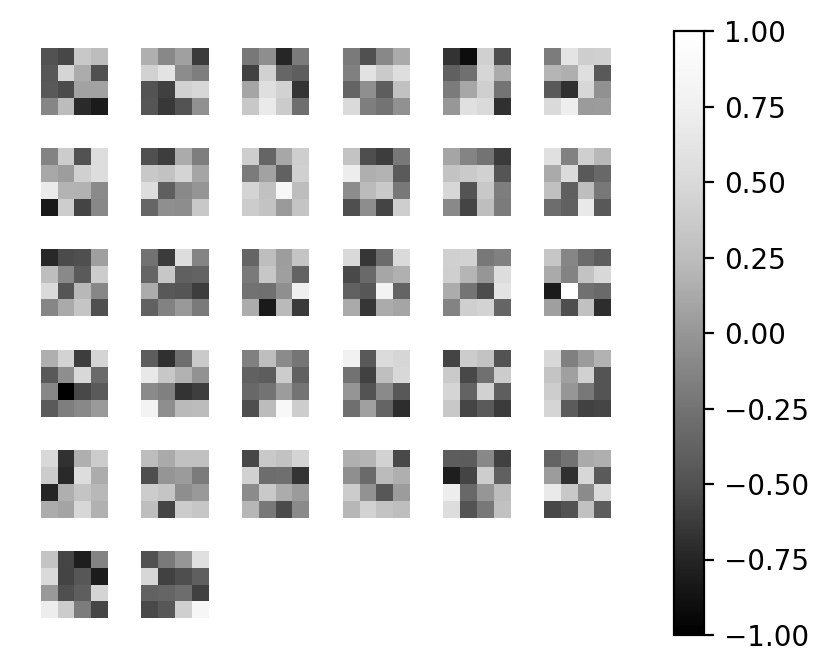

In [33]:
bw = test_outweights_ordered.reshape(encoding_model.params['imxlen'],
                                     encoding_model.params['imylen'],
                                     encoding_model.params['nneurons']).T
p = plu.plot_tiled_rfs(fw)

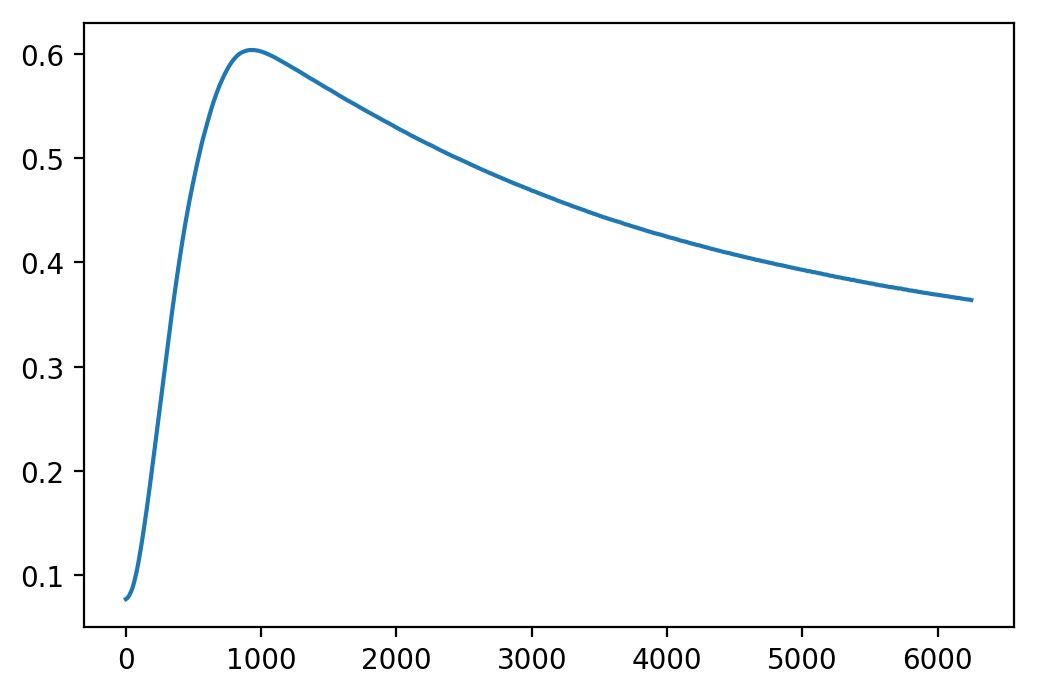

In [10]:
p = plt.plot(wmean_evolution)

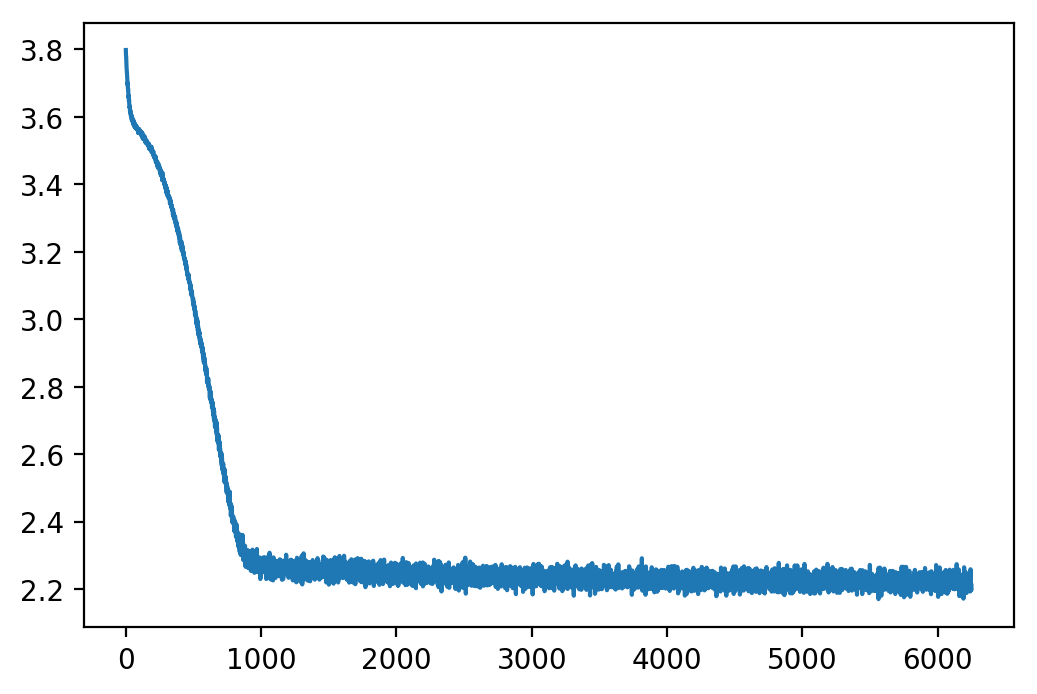

In [11]:
p = plt.plot(np.log(cost_evolution))

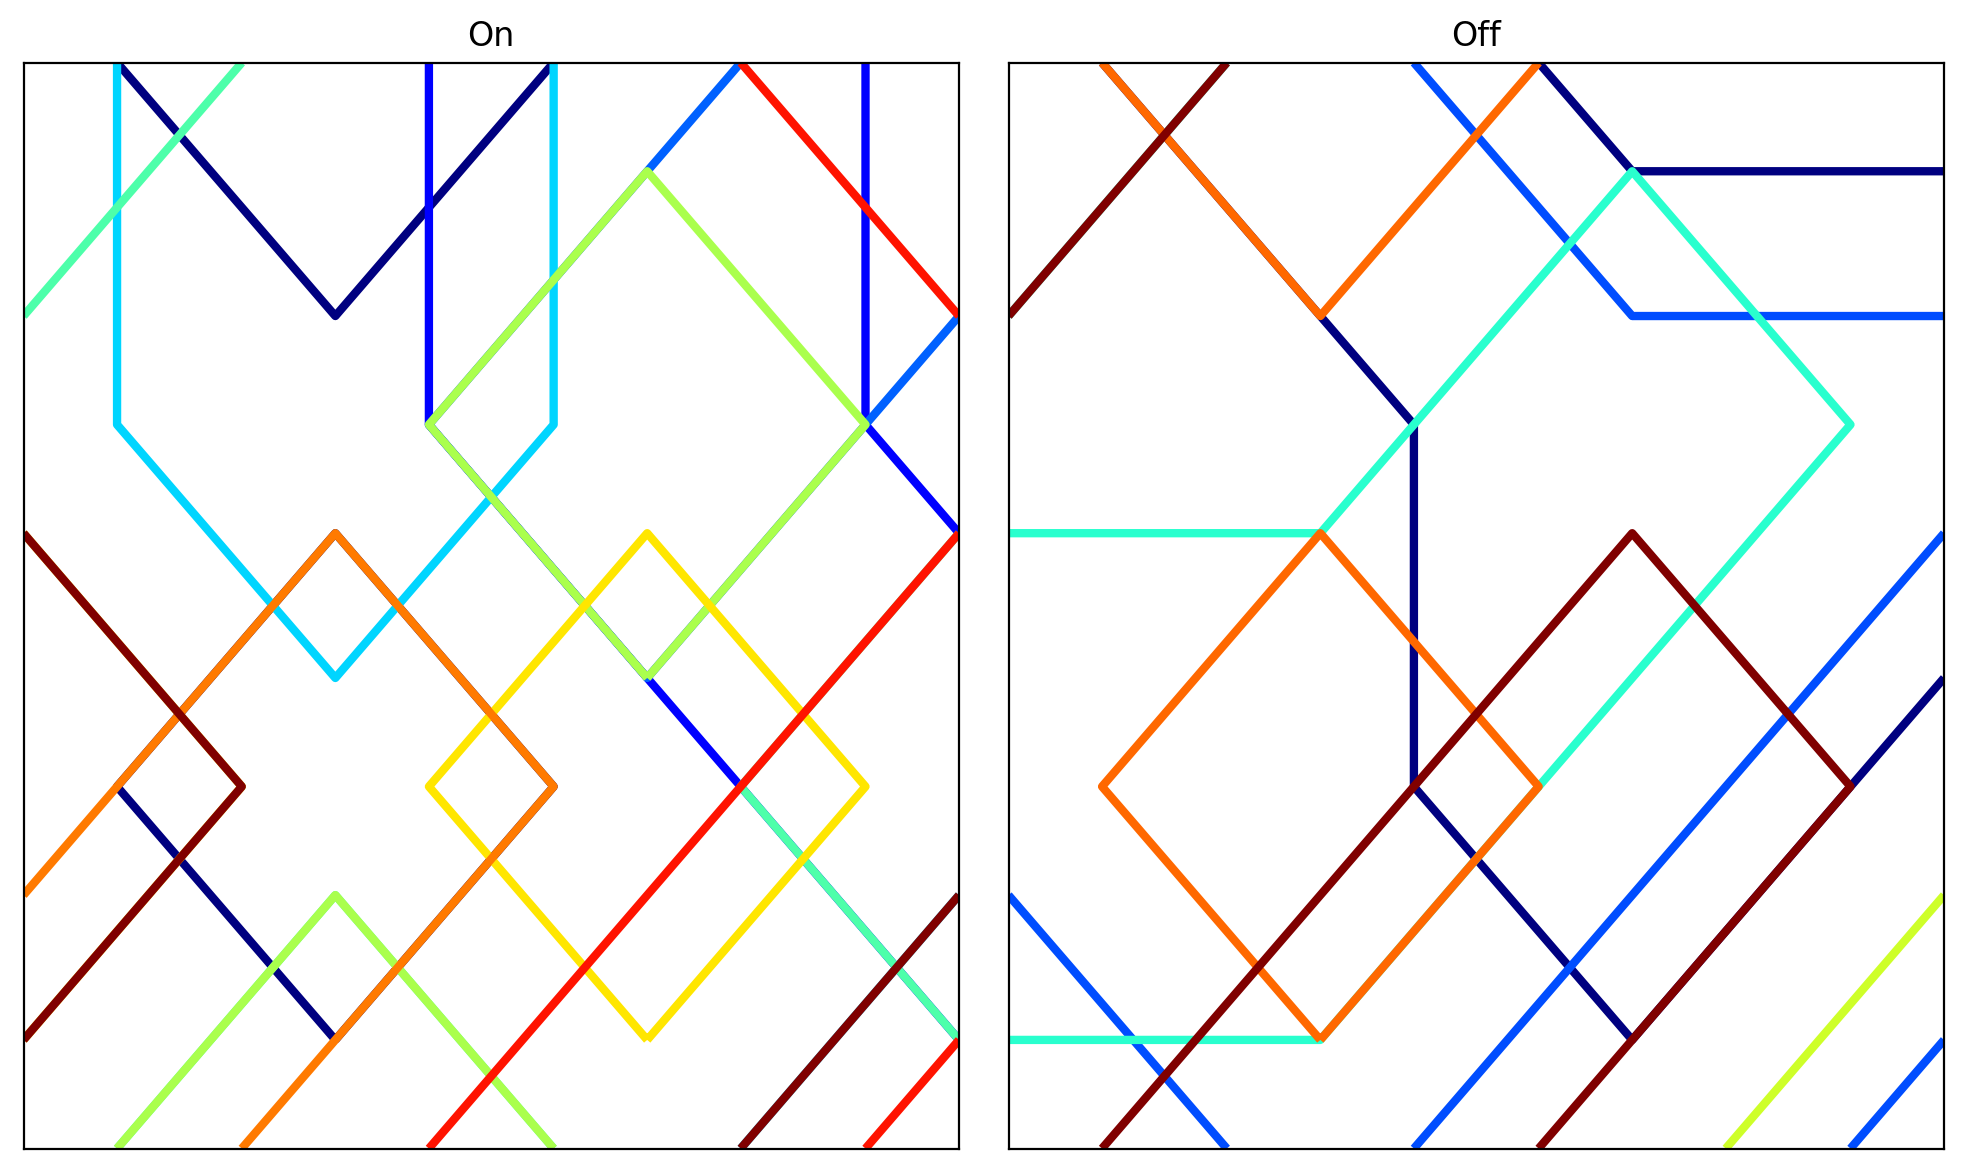

In [12]:
imp.reload(plu)
onofflabel, onoff = plu.plotonoff(fw)

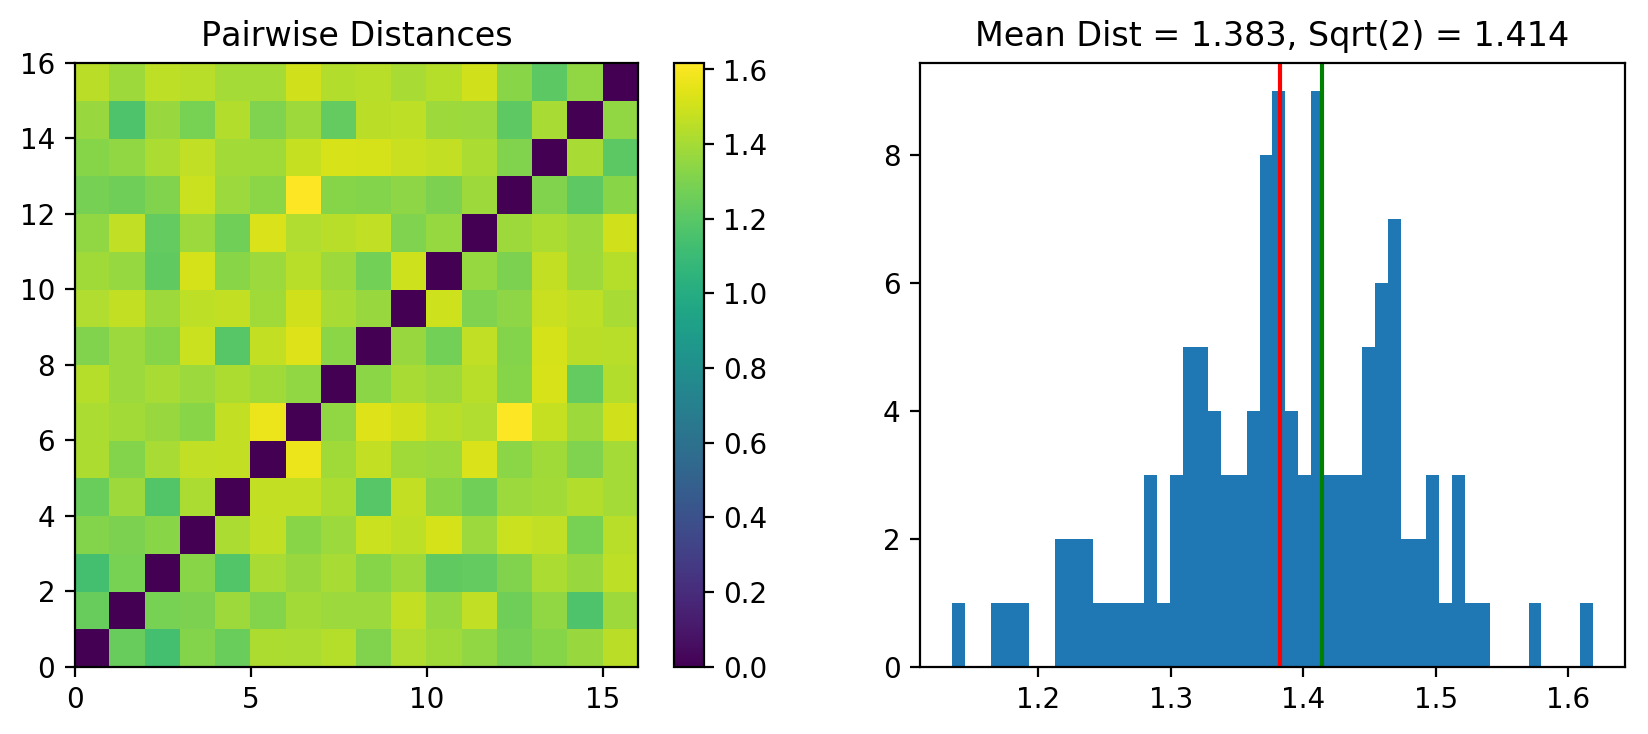

In [13]:
distmat, plot = plu.measure_plot_dist(fw, norm=1)

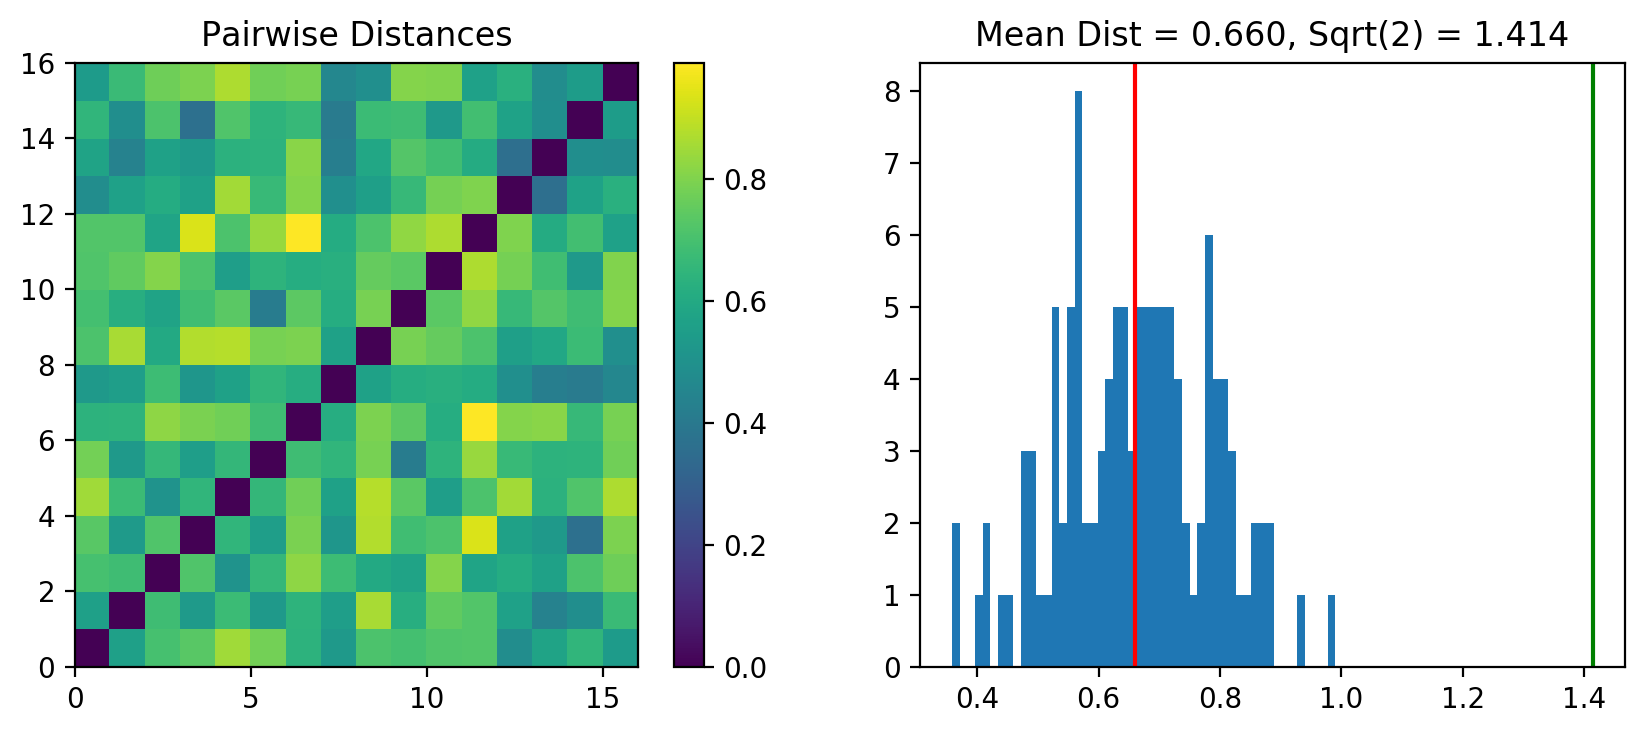

In [14]:
#Uniformly distributed Random
r = np.random.rand(*fw.shape)
distmat, plot = plu.measure_plot_dist(r, norm=1)

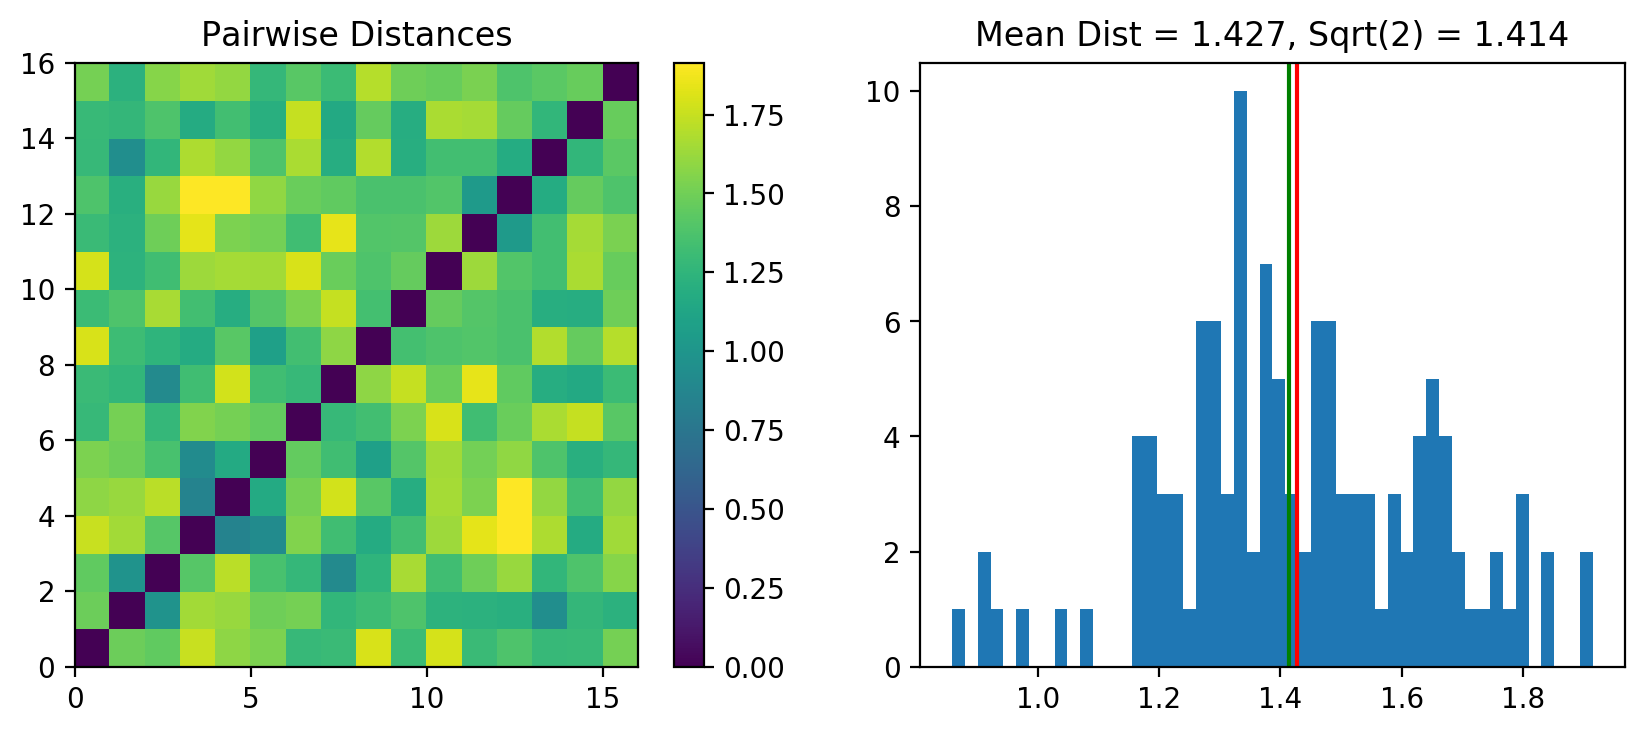

In [15]:
#normally distributed Random
r = np.random.randn(*fw.shape)
distmat, plot = plu.measure_plot_dist(r, norm=1)

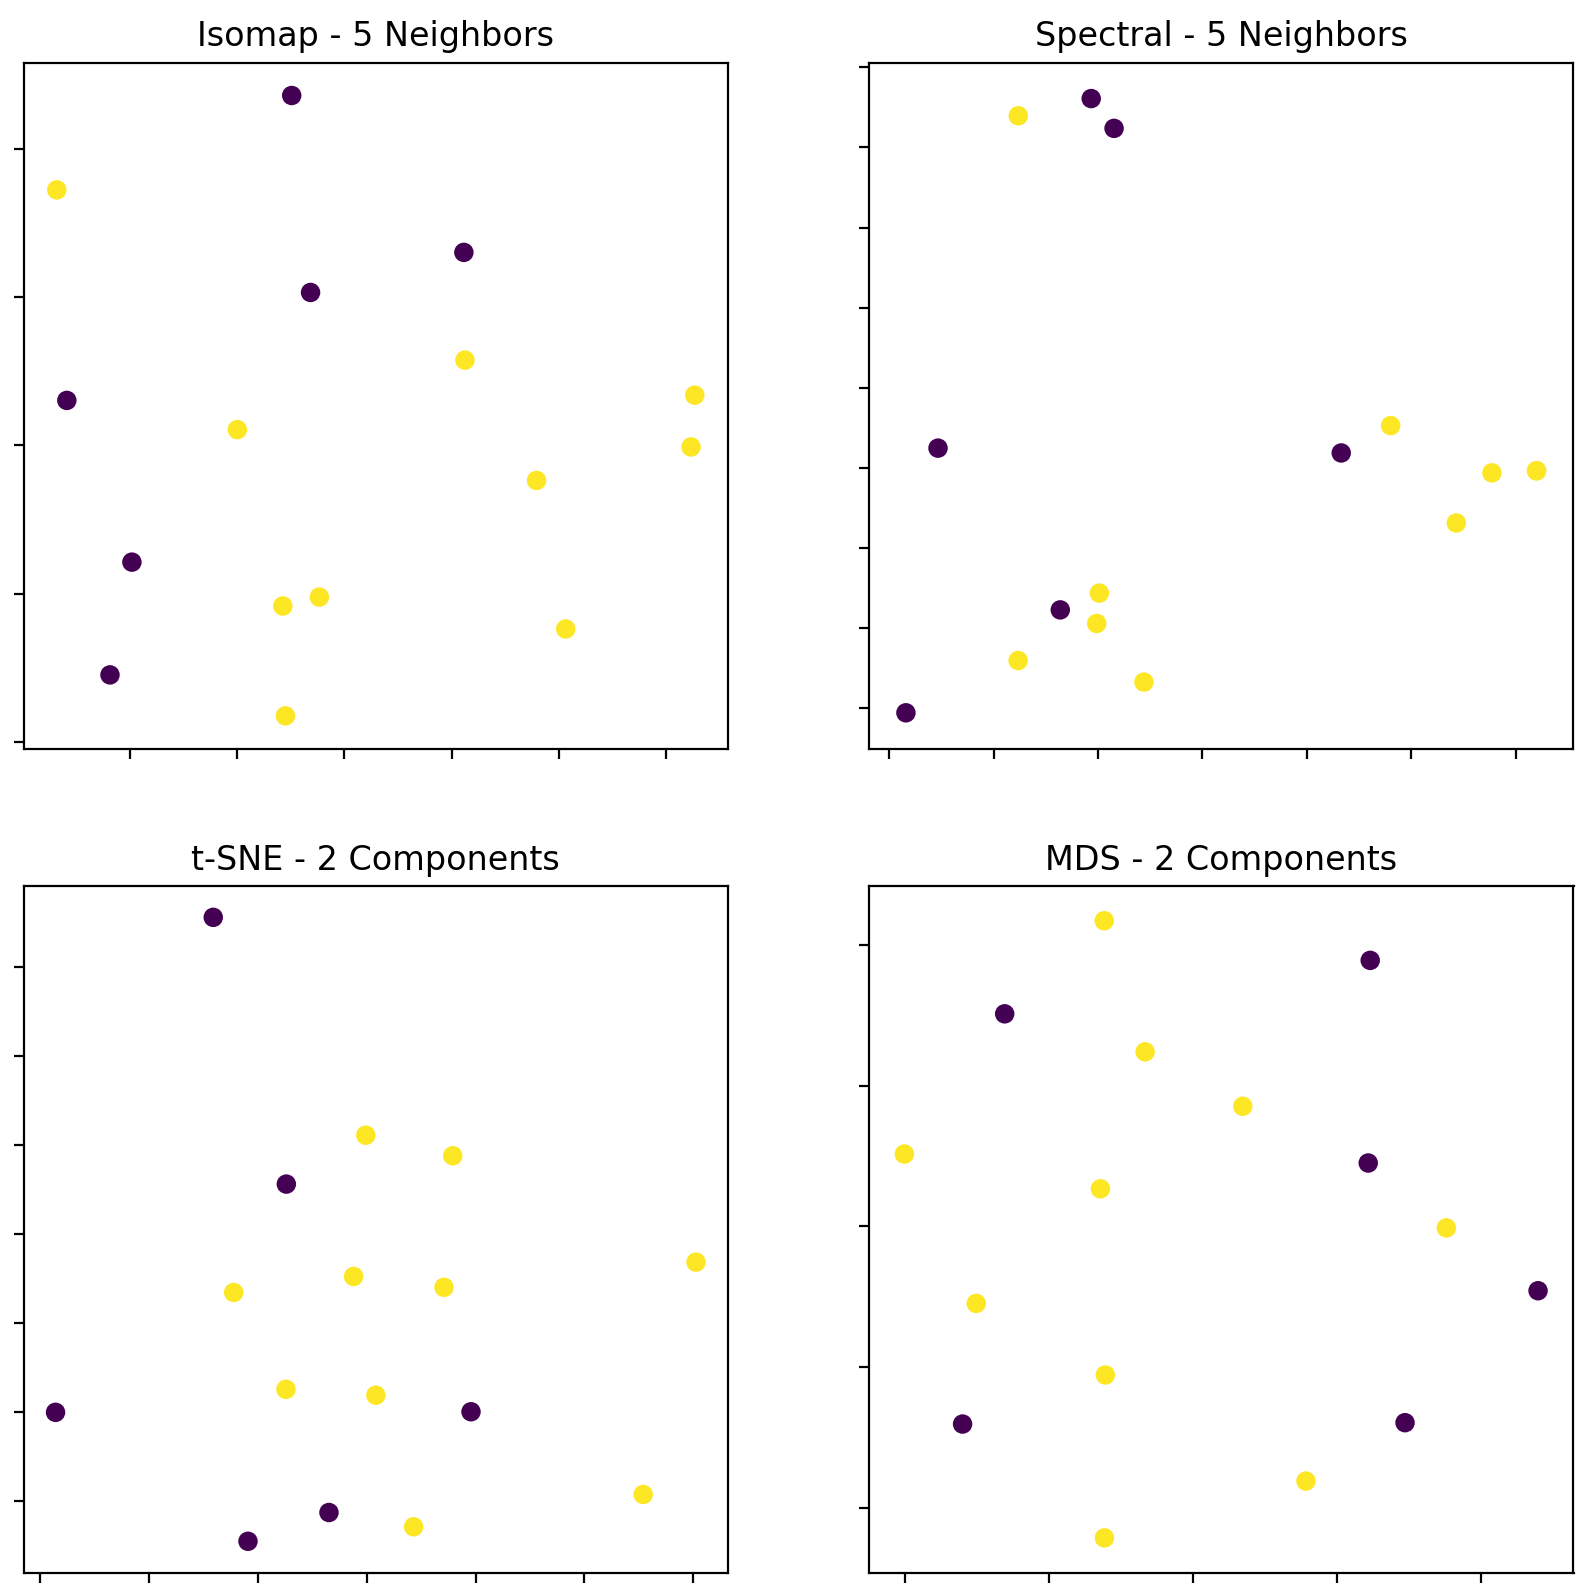

In [16]:
p = plu.plot_dist_embeddings(distmat, onofflabel, n_neighbors=5)

## Look at Activations

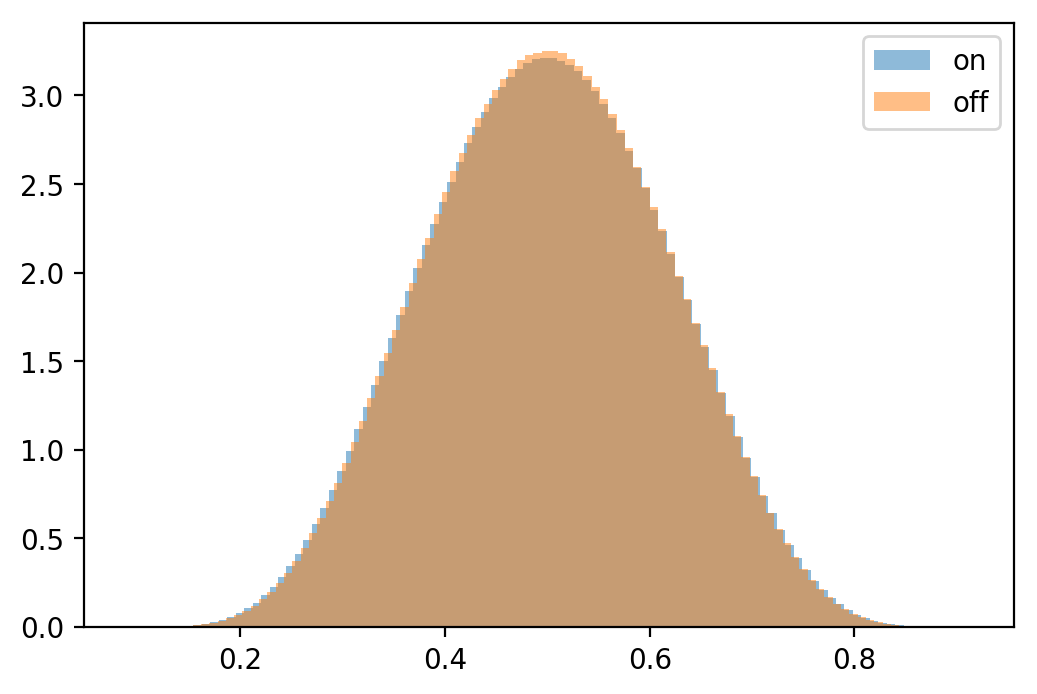

In [27]:
imp.reload(plu)
p = plu.test_activation_distributions(test_acts_ordered, onofflabel, norm=True)

## Look at Distances Between Activations

In [28]:
print(np.shape(actv))
pactv = actv[:,:1000]
print(np.shape(pactv))

NameError: name 'actv' is not defined

In [ ]:
act_distmat, p = plu.measure_plot_dist(np.array(pactv).T,norm=2)

In [ ]:
#calcuate Johnson Bound for L1 norm (instead of Hamming)
#blocklength
n = act_distmat.shape[0]
#dimension k
k = fw.reshape(fw.shape[0],-1).shape[0]
#rate p
p = k/n
#min distance
dmin = min(distmat.flatten())
#size of code C
sizec = distmat.shape[1]
#alphabet size q

In [ ]:
p = plu.plot_dist_embeddings(act_distmat, np.ones(act_distmat.shape[0]), n_neighbors=5)